In [90]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os
import utils
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.10f' % x)

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn


In [91]:
X_train_std, X_test_std, Y_train, Y_test = utils.get_train_test_split()
Y_train.dtype


dtype('int64')

In [92]:
from typing import Tuple


class SuicideDataSet(Dataset):
    def __init__(self, test=False):
        self.test = test
        self.X_train_std, self.X_test_std, self.Y_train, self.Y_test = utils.get_train_test_split()

    def __len__(self):
        return len(Y_test if self.test else Y_train)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        ftrs = X_test_std[idx] if self.test else X_train_std[idx]
        label = Y_test[idx] if self.test else Y_train[idx]
        ftrs = torch.tensor(ftrs).float()
        label = torch.tensor(label).float()
        return ftrs, label


In [93]:
class SuicideRegressor(nn.Module):
    def __init__(self, in_features) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,8),
            nn.ReLU(),
            nn.Linear(8,1),
        )

    def forward(self, x):
        return self.model(x)

In [143]:
class SuicideRegressorBN(nn.Module):
    def __init__(self, in_features) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.BatchNorm1d(num_features=in_features),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=256),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=64),
            nn.Linear(64, 8),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=8),
            nn.Linear(8, 1),
        )

    def forward(self, x):
        return self.model(x)

## Train model

In [94]:
train_ds = SuicideDataSet(test=False)
train_loader = DataLoader(dataset=train_ds, batch_size=1788)

test_ds = SuicideDataSet(test=True)
test_loader = DataLoader(dataset=test_ds, batch_size=276)

a = iter(train_loader)
b = a._next_data()
print(b)
# print(b)


[tensor([[0.0000, 0.7500, 1.0000,  ..., 0.9888, 0.3300, 0.0717],
        [0.0000, 0.7500, 1.0000,  ..., 0.9888, 0.3300, 0.0134],
        [0.0000, 0.7500, 1.0000,  ..., 0.9888, 0.3300, 0.0374],
        ...,
        [1.0000, 0.5000, 0.0000,  ..., 0.3427, 0.5589, 0.2713],
        [1.0000, 0.5000, 1.0000,  ..., 0.3427, 0.5589, 0.4968],
        [1.0000, 0.5000, 0.0000,  ..., 0.3427, 0.5589, 0.4751]]), tensor([816., 151., 311.,  ..., 477., 277., 151.])]


In [113]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="./tb_logs")



In [144]:

EPOCHS = 3_000
model = SuicideRegressorBN(in_features=9)
criterion = nn.MSELoss()
optim = torch.optim.Adam(
    params=model.parameters(),
    lr=5e-3,
    weight_decay=1e-4
)

for epoch in range(EPOCHS):
    model.train()
    loss = 0
    for batch_ftrs, batch_labels in train_loader:
        optim.zero_grad()
        y_pred = model(batch_ftrs)
        train_loss = criterion(y_pred[:,0], batch_labels)
        train_loss.backward()

        optim.step()
        loss += train_loss.item()

    loss = loss / len(train_loader)

    # compute validation loss
    val_loss = 0
    with torch.no_grad():
        model.eval()
        for batch_ftrs, batch_labels in test_loader:
            y_pred = model(batch_ftrs)
            cur_loss = criterion(y_pred[:,0], batch_labels)
            val_loss += cur_loss.item()
        val_loss = val_loss / len(test_loader)
    # prints
    if epoch % 200 == 0:
        print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, EPOCHS, loss))
        print("epoch : {}/{}, val_loss = {:.6f}".format(epoch + 1, EPOCHS, val_loss))
     # add scalars to tensorboard
    writer.add_scalar(f"{criterion}/train", loss, epoch + 1)
    writer.add_scalar(f"{criterion}/val", val_loss, epoch + 1)

    writer.flush()

epoch : 1/3000, train_loss = 1116156.750000
epoch : 1/3000, val_loss = 1229682.250000
epoch : 201/3000, train_loss = 1053881.375000
epoch : 201/3000, val_loss = 1162609.125000
epoch : 401/3000, train_loss = 913166.437500
epoch : 401/3000, val_loss = 1019378.875000
epoch : 601/3000, train_loss = 724228.750000
epoch : 601/3000, val_loss = 821980.250000
epoch : 801/3000, train_loss = 533748.437500
epoch : 801/3000, val_loss = 619128.750000
epoch : 1001/3000, train_loss = 373427.687500
epoch : 1001/3000, val_loss = 448015.625000
epoch : 1201/3000, train_loss = 250386.015625
epoch : 1201/3000, val_loss = 311365.875000
epoch : 1401/3000, train_loss = 94593.781250
epoch : 1401/3000, val_loss = 109636.945312
epoch : 1601/3000, train_loss = 39092.527344
epoch : 1601/3000, val_loss = 47412.160156
epoch : 1801/3000, train_loss = 13105.385742
epoch : 1801/3000, val_loss = 18770.488281
epoch : 2001/3000, train_loss = 3551.379639
epoch : 2001/3000, val_loss = 8335.477539
epoch : 2201/3000, train_los

In [145]:
torch.save(model, "torch_models/bn_1.pickle")

In [146]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

with torch.no_grad():
    model.eval()
    pred = model(torch.tensor(X_test_std).float())
    custom_mlp_pred = pred[:, 0]


## compare with sklearn MLP

In [132]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(
    hidden_layer_sizes=[512,256,64,8],
    max_iter=3000,
    activation='relu')
mlp_model.fit(X_train_std,Y_train)

MLPRegressor(hidden_layer_sizes=[512, 256, 64, 8], max_iter=3000)

In [147]:
mlp_pred = mlp_model.predict(X_test_std)
metrics = [mean_squared_error, mean_absolute_error, median_absolute_error]
model_preds = {
    'mlp': mlp_pred,
    'custom_mlp': custom_mlp_pred
}


for metric in metrics:
    print(f"{metric.__name__} eval:")
    for model, pred in model_preds.items():
        score = metric(y_true=Y_test, y_pred=pred)
        print(f"{model}: {score}")
    print('-'*10)

mean_squared_error eval:
mlp: 16454.037406289903
custom_mlp: 4001.4091741490615
----------
mean_absolute_error eval:
mlp: 71.54075694966531
custom_mlp: 34.204652908487596
----------
median_absolute_error eval:
mlp: 34.91267247662593
custom_mlp: 17.990802764892578
----------


(<AxesSubplot: >,)

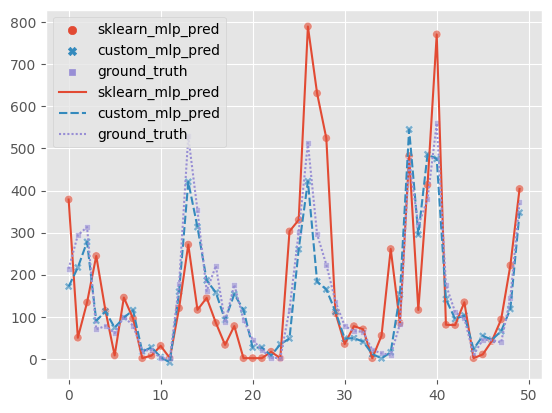

In [150]:
n_samples = 50
pred_df = pd.DataFrame({
    'sklearn_mlp_pred': mlp_model.predict(X_test_std)[:n_samples],
    'custom_mlp_pred' : custom_mlp_pred[:n_samples],
    'ground_truth': Y_test[:n_samples]
})
sns.scatterplot(pred_df, markers=True, alpha=.6)
sns.lineplot(pred_df)